# Dask

by Martin Hronec


* Python library for parallel computing
    * multi-core and distributed parallel execution on larger-than-memory datasets

* **distributed**: leveraging multiple cores/computers
* **parallel**: using more cores on your computer(s) at once    
* **larger-than-memory**: handles datasets larger than operating memory

* why it's cool: 
    * familiarity (similar to np and pd objects and methods)
    * fast (low overhead, low latency, etc.)
    * flexibility (can be customized - easily)
    * scales up (clusters of computers/cores)
    * scales down (can be usefull also for single laptop)

* consists of "high level" and "low level" parts:

![pic](https://docs.dask.org/en/latest/_images/dask-overview.svg)

* **high level collections:** Array, Bag, DataFrame (alternatives to NumPy, Pandas, Python iterators, etc. for large datasets.)

* **low level schedulers:** dynamic task schedulers executing task graphs in parallel (alternative to direct use of threading or multiprocessing) 


* Dask has 2 families of task schedulers:
    * single machine scheduler (provides basic features on a local process or thread pool) - default
    * distributed scheduler

* when to use [threads vs. processes on scheduler](https://docs.dask.org/en/latest/setup/single-machine.html)

* [example usecases](https://stories.dask.org/en/latest/)    

* number of ways to execute code in parallel
    * `dask.delayed`
    * `dask.array`,`dask.dataframe`, `dask.bag` (collections)

* we will use Dask Dashboard to gain insight into what's going on under the hood

* this follows number of official dask materials that can be found on the official [website](https://docs.dask.org/en/latest/)

In [82]:
# using distributed scheduler
from dask.distributed import Client

client = Client(n_workers=4,memory_limit='1GB')
client

/home/crozier/.local/lib/python3.8/site-packages/distributed/node.py:151: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 43125 instead
  warnings.warn(


Client Scheduler: tcp://127.0.0.1:42053 Dashboard: http://127.0.0.1:43125/status,Cluster Workers: 4 Cores: 8 Memory: 4.00 GB


## `dask.delayed`
* easy to parallelize existing codebases
* offers flexibility to build complex models, e.g. [Credit Modeling with Dask](https://blog.dask.org/2018/02/09/credit-models-with-dask)
* idea is to wrap functions (decorate) in `dask.delayed`, which makes them lazily evaluated delayed objects (remember the last lecture on generators)
    * "lazily evaluated" means dask does not call the functions until it needs it, i.e. when we actually call `.compute()`
* Dask can then represent the computation problem, figure out how to execute it the most efficiently and only then do the computation

### 1st parallelization example

* basic example which could be parallelized
    * calling functions sequentially first
    * since they are independent, we can parallelize
    
(added 1 second sleep to make the point)

In [5]:
from time import sleep

def inc(x):
    sleep(1)
    return x + 1

def add(x, y):
    sleep(1)
    return x + y

In [6]:
%%time
x = inc(1)
y = inc(2)
z = add(x, y)

CPU times: user 671 ms, sys: 110 ms, total: 781 ms
Wall time: 3 s


* we will transform the funtions using the `dask.delayed` function
* when we call the delayed version, the original function isn't actually called yet
* instead, a delayed object is made
    * it keeps track of the function to call and the arguments to pass to it
* to get the results we need to call `compute`

In [7]:
from dask import delayed

In [10]:
%%time

x = delayed(inc)(1)
y = delayed(inc)(2)
z = delayed(add)(x, y)

CPU times: user 1.06 ms, sys: 0 ns, total: 1.06 ms
Wall time: 884 µs


In [12]:
%%time 
z.compute()

CPU times: user 714 ms, sys: 124 ms, total: 838 ms
Wall time: 2.04 s


5

* the `z` object is a lazy Delaed object
* it holds everything we need to compute the final result (including references to all of the functions that are required and their inputs and relationships to one-another
* we can get actual results (after actual computation) with `.compute`
* we can also visualize the task graph with `.visualize()`
    * circles represent the function calls (with the name of the function inside the circle)
    * rectangles represent the outputs

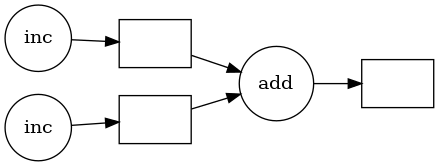

In [11]:
z.visualize(rankdir='LR')

Questions:
* Why did we go from 3s to 2s? Why weren't we able to parallelize down to 1s?
* What would have happened if the inc and add functions didn't include the sleep(1)? Would Dask still be able to speed up this code?


### Parallelize a for loop 

* for loops are one of the most common things that we want to parallelize


In [13]:
data = [1, 2, 3, 4, 5, 6, 7, 8]

In [14]:
%%time
# Sequential code

results = []
for x in data:
    y = inc(x)
    results.append(y)
    
total = sum(results)

CPU times: user 2.21 s, sys: 387 ms, total: 2.6 s
Wall time: 8.01 s


In [15]:
# Parallel version
results = []

for x in data:
    y = delayed(inc)(x)
    results.append(y)
    
total = delayed(sum)(results)

In [16]:
total

Delayed('sum-10d48b90-8c3d-4bfe-9109-54ff0a2150fe')

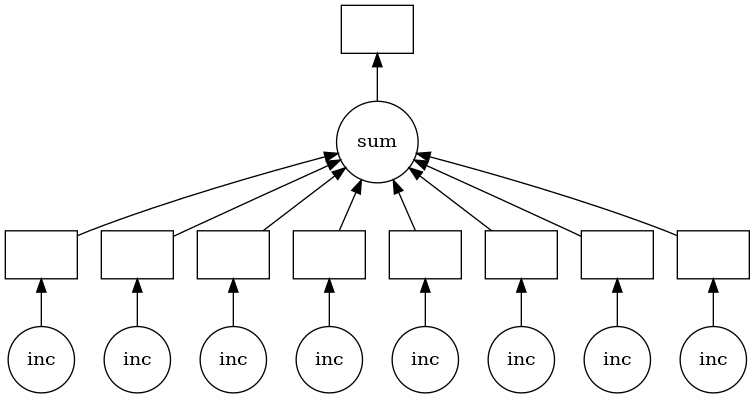

In [17]:
total.visualize()

In [18]:
%%time
result = total.compute()

CPU times: user 387 ms, sys: 55.4 ms, total: 442 ms
Wall time: 1.05 s


* you can add/multiply/etc. delayed objects together to get another delayed object (with associated task graph on the backend)  

In [19]:
# returns another delayed object 
delayed(inc)(1) + delayed(inc)(2)

Delayed('add-638f6a85dfd8a404ef2f9c982d617576')

### Parallelize a for-loop with a control flow

* often we want to delay only some function, while running a others immediately
    * it is especially helpful to run functions which are fast and help us to determine what other slower functions we should call
    
* "to delay or not to delay"
    * the most important question when using `dask.delayed`

In [20]:
data = list(range(1,11))

In [21]:
def double(x):
    sleep(1)
    return 2*x

def is_even(x):
    return not x % 2 

In [22]:
%%time
# Sequential code

results = []
for x in data:
    if is_even(x):
        y = double(x)
    else:
        y = inc(x)
    results.append(y)
    
total = sum(results)
print(total)


90
CPU times: user 3.01 s, sys: 566 ms, total: 3.58 s
Wall time: 10 s


* parallelizing above, but note that we've delayed only some but not all functions 
* we did not delay function used in the conditional statement

In [23]:
%%time
results = []
for x in data:
    if is_even(x):
        y = delayed(double)(x)
    else:  
        y = delayed(inc)(x)
    results.append(y)
    
total = delayed(sum)(results)

CPU times: user 2.02 ms, sys: 0 ns, total: 2.02 ms
Wall time: 1.37 ms


In [24]:
%%time 
total.compute()

CPU times: user 560 ms, sys: 60.5 ms, total: 620 ms
Wall time: 2.04 s


90

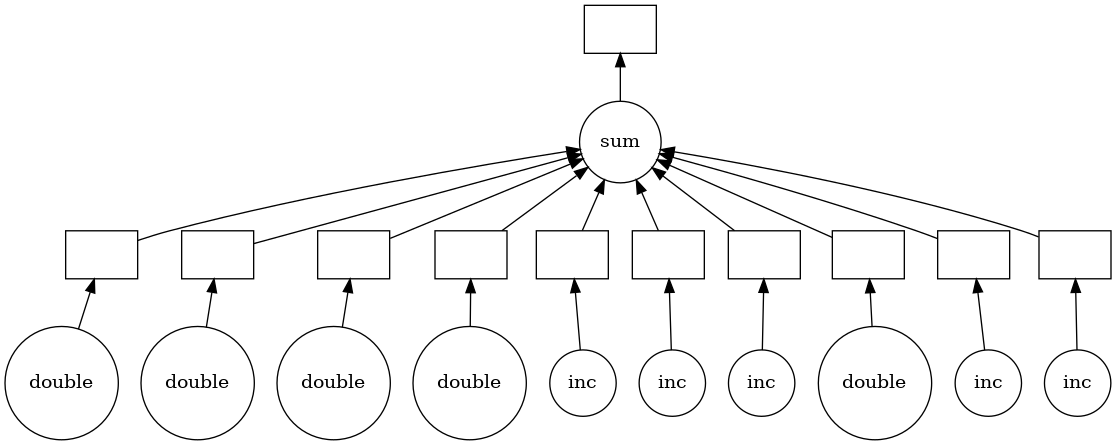

In [25]:
total.visualize()

In [26]:
dict(total.dask)

{'sum-74cd0877-1f80-4ea0-9f23-496a2439bbc9': (<function sum(iterable, /, start=0)>,
  ['inc-2442f8cc-f274-4f40-9388-aebe1fa38da5',
   'double-b6b49c4d-6396-4020-ad55-a7b8a1745fcb',
   'inc-00b4e00c-eb4d-4add-97c4-d704e0499116',
   'double-980e3992-39ec-462e-9863-e2bddaf7042f',
   'inc-ad7bb763-5b20-4323-8aaa-a62a21028ee0',
   'double-da95f3af-fea9-4c84-bdc1-9f157fdfda45',
   'inc-b43d84f1-d8a6-46c0-82f1-287182fe0a90',
   'double-44c7e3a4-7ad9-4761-9217-1fb059a3a6e1',
   'inc-a4e9b8f4-1ccd-40cd-bb9b-eaa5223a17d7',
   'double-f05c872a-26e8-44f2-aa22-76e9a74759e8']),
 'inc-2442f8cc-f274-4f40-9388-aebe1fa38da5': (<function __main__.inc(x)>, 1),
 'double-b6b49c4d-6396-4020-ad55-a7b8a1745fcb': (<function __main__.double(x)>,
  2),
 'inc-00b4e00c-eb4d-4add-97c4-d704e0499116': (<function __main__.inc(x)>, 3),
 'double-980e3992-39ec-462e-9863-e2bddaf7042f': (<function __main__.double(x)>,
  4),
 'inc-ad7bb763-5b20-4323-8aaa-a62a21028ee0': (<function __main__.inc(x)>, 5),
 'double-da95f3af-fea9-

Questions:

* What are other examples of control flow where we can't use delayed?
    * e.g. you cannot check if some value is greater than some threshold (since we don't know the value, while it is delayed)
* What would have happened if we had delayed the evaluation of is_even(x) in the example above?
    * error: Truth of the delayed object is not supported 


## Arrays

* `dask.delayed` used when working with custom functions
* when using more high level objects, we can also use more high level Dask objects, e.g. Dask arrays
* Dask arrays are a parallel, larger-than-memory, n-dimentional arrays ("distributed Numpy")
* to create a `dask.array` Array object, use `da.from_array` function
    * accepts `data` which is any array-like object (e.g. np array)
    * and `chunks` telling how to break up the array into pieces/chunks

In [66]:
import dask.array as da
import numpy as np

In [67]:
client

Client Scheduler: tcp://127.0.0.1:38683 Dashboard: http://127.0.0.1:44963/status,Cluster Workers: 4 Cores: 8 Memory: 4.00 GB


In [83]:
a = np.random.rand(int(1e8))

# constructs a dask array from np.array
n_chunks = 20
a_dask = da.from_array(a,chunks = len(a) // n_chunks)

In [94]:
a_dask

dask.array<array, shape=(100000000,), dtype=float64, chunksize=(5000000,), chunktype=numpy.ndarray>

* let's first do some np operations

In [100]:
%%time
### Aggregating with np Arrays
n_chunks = 20
chunk_size = len(a) // n_chunks

# accumulate sum explicitly  
result = 0

# within the loop, slice each chunk explicitly, by finding its offset,
# i.e. actual index where each chunk begins
# each loop is independent, could be executed in parallel
for k in range(n_chunks):
    offset = k * chunk_size # track offset explicitly
    a_chunk = a[offset:offset + chunk_size] # slice chunk explicitly
    result += a_chunk.sum()
    
result

CPU times: user 63.6 ms, sys: 14.6 ms, total: 78.2 ms
Wall time: 61.5 ms


49996245.93672056

In [102]:
a_dask

dask.array<array, shape=(100000000,), dtype=float64, chunksize=(5000000,), chunktype=numpy.ndarray>

In [103]:
%%time
### Aggregating with Dask Arrays

# constructs a dask array from np.array
a_dask = da.from_array(a,chunks = len(a) // n_chunks)
result = a_dask.sum()

result.compute()

CPU times: user 1.33 s, sys: 687 ms, total: 2.01 s
Wall time: 1.87 s


49996245.93672056

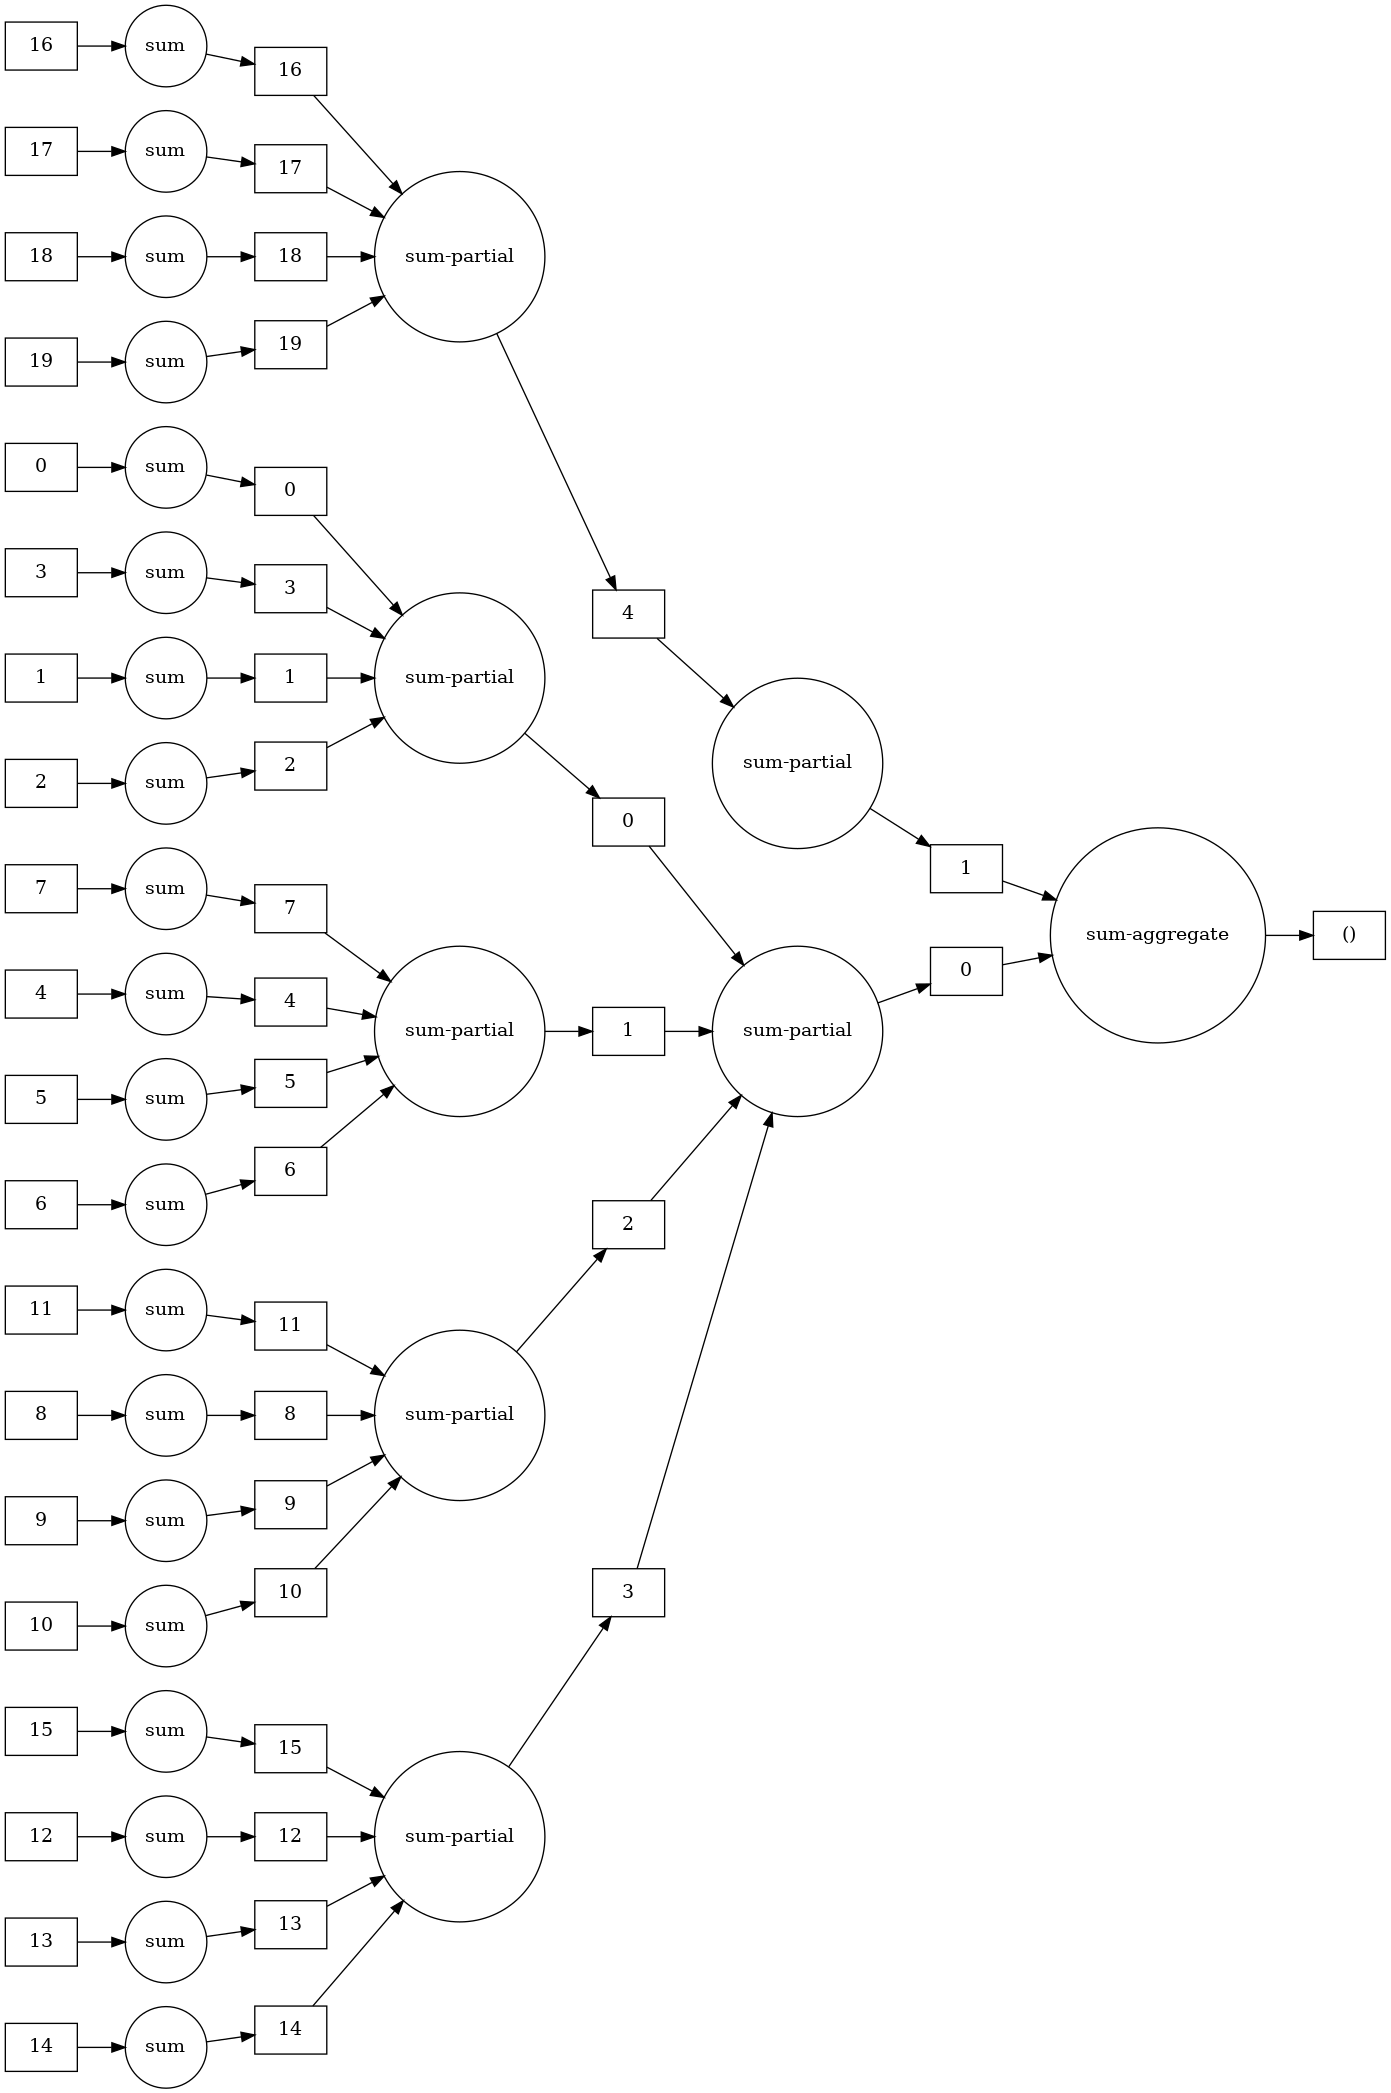

In [104]:
# create graph
result.visualize(rankdir='LR')

In [107]:
x = da.random.normal(10, 0.1, size=(20000, 20000),   # 400 million element array
                              chunks=(1000, 1000))   # Cut into 1000x1000 sized chunks
y = x.mean(axis=0)[::100]                            # Perform NumPy-style operations

In [108]:
x.nbytes / 1e9  # Gigabytes of the input processed lazily

3.2

In [109]:
%%time
y.compute()     # Time to compute the result

CPU times: user 1.29 s, sys: 179 ms, total: 1.47 s
Wall time: 2.78 s


array([10.00002252,  9.99917438, 10.00083877, 10.00064097, 10.00032932,
       10.0006869 ,  9.99964233,  9.99955505, 10.00039712, 10.00029569,
       10.00091341,  9.99989712,  9.99992996, 10.00060159, 10.00002755,
        9.99961715, 10.00001878,  9.9993171 ,  9.99989304, 10.00104786,
       10.00035495, 10.0004969 ,  9.99987192,  9.99980111, 10.00120954,
       10.00011062, 10.00127877,  9.99842613,  9.99959064,  9.99979807,
       10.00028697,  9.99841817,  9.99913478,  9.99884076,  9.99973929,
       10.00073909, 10.00069906,  9.99991667,  9.99983885, 10.00021105,
       10.00059909,  9.99897962,  9.99968742, 10.00077231, 10.00013619,
       10.00006424, 10.00004133,  9.99966533, 10.0004692 ,  9.99917814,
        9.99966067, 10.00000644,  9.99869979,  9.99955835, 10.00005672,
        9.99980509, 10.00122836,  9.99928305,  9.99924003, 10.00020756,
        9.99930942,  9.9992298 , 10.00016612,  9.99951814,  9.9998607 ,
        9.99970437,  9.99971653,  9.99959987,  9.9999615 ,  9.99

dot: graph is too large for cairo-renderer bitmaps. Scaling by 0.399009 to fit


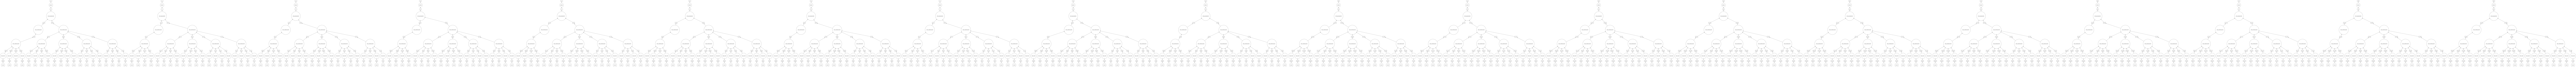

In [110]:
y.visualize()

In [113]:
%%time
x = np.random.normal(10, 0.1, size=(20000, 20000))
y = x.mean(axis=0)[::100]
y

CPU times: user 10.7 s, sys: 461 ms, total: 11.2 s
Wall time: 9.42 s


array([10.00101152,  9.9989518 ,  9.99957007, 10.00087974, 10.00048137,
        9.99999289,  9.99881718,  9.99952043, 10.0002271 , 10.00049488,
       10.00013712, 10.00055814, 10.0008864 ,  9.9998154 , 10.00078008,
       10.00057044,  9.99887663,  9.99972893,  9.99971386, 10.00014247,
        9.9996728 ,  9.99998854, 10.00022717, 10.00103228, 10.00072462,
       10.00025837, 10.00080145,  9.99944583, 10.00122083,  9.99899681,
        9.99917311,  9.9997229 , 10.00027071,  9.99994179, 10.00170418,
       10.00042921, 10.00107484,  9.99938992,  9.99943023, 10.00019317,
       10.00081902, 10.00071811,  9.99956331, 10.00058893,  9.9999227 ,
        9.99998529,  9.99980848, 10.00134224,  9.99986728, 10.00126639,
       10.00056358, 10.00109143,  9.99967399,  9.99953292, 10.00009002,
        9.99978474, 10.00006738,  9.99897177, 10.00097167, 10.00019366,
       10.00032304, 10.00060722, 10.00023807, 10.0007707 , 10.00164498,
       10.000308  , 10.00009852, 10.00074007,  9.99904476, 10.00

In [114]:
%%time
x = da.random.normal(10, 0.1, size=(20000, 20000), chunks=(1000, 1000))
y = x.mean(axis=0)[::100]
y.compute()

CPU times: user 1.52 s, sys: 140 ms, total: 1.66 s
Wall time: 3.08 s


array([10.00072262,  9.99961319, 10.00008532,  9.99970085,  9.99929452,
       10.00005614,  9.99963272,  9.99987998, 10.00069359, 10.00067227,
        9.99906289, 10.00015287, 10.000118  , 10.0000022 , 10.00013371,
        9.99990135, 10.00013274,  9.99793884,  9.99984409,  9.99923607,
        9.99814701, 10.00106487, 10.00046831, 10.00016243,  9.99935885,
        9.99971104, 10.00111298,  9.99941925,  9.9992602 ,  9.99833536,
        9.99946953,  9.99999343, 10.00083371,  9.99980821, 10.0018706 ,
       10.00122123,  9.99943608, 10.00077111, 10.00122594, 10.0011543 ,
       10.00037421,  9.99999735, 10.00076195, 10.00078532, 10.00072656,
       10.00008158,  9.99865208,  9.99989329, 10.0000377 , 10.00000594,
       10.00009287,  9.9985152 , 10.00087373, 10.00015869,  9.99915539,
       10.00062062,  9.99938966,  9.99987842,  9.99937874,  9.99979506,
       10.00005844, 10.00067974,  9.9994569 , 10.00038424, 10.00017004,
        9.99964228,  9.99952623,  9.99966269,  9.9998992 , 10.00

### Caveats:

* `dask.array` does not (and can not) replicate the whole numpy library 
* Dask does not implement `np.linalg`
* `dask.array` does not support `sort`ing - difficult to do in parallel
    * parallel friendly alternative `topk` 

## Dask DataFrames

* a delayed version of Pandas DataFrame
    * Pandas is great for datasets that fit in memory!
* substantial overlap of pandas and dask functionality
* capabilities:
    * manipulating large datasets (even when those datasets don’t fit in memory)
    * accelerating long computations by using many cores
    * distributed computing on large datasets with standard Pandas operations like groupby, join, and time series computations

* one dask DataFrame is comprised of many in-memory pandas DataFrames separated along the index

In [115]:
import dask
import dask.dataframe as dd

In [116]:
??dd.read_csv;

Object `dd.read_csv;` not found.


* we can also use so called *glob* pattern: `dd.read_csv('*.csv')`

In [117]:
df = dd.read_csv(os.path.join('dask_data','nycflights','*.csv'),
                parse_dates={'Date':[0,1,2]})

In [118]:
df

,Date,DayOfWeek,DepTime,CRSDepTime,ArrTime,CRSArrTime,UniqueCarrier,FlightNum,TailNum,ActualElapsedTime,CRSElapsedTime,AirTime,ArrDelay,DepDelay,Origin,Dest,Distance,TaxiIn,TaxiOut,Cancelled,Diverted
npartitions=10,,,,,,,,,,,,,,,,,,,,,
,datetime64[ns],int64,float64,int64,float64,int64,object,int64,float64,float64,int64,float64,float64,float64,object,object,float64,float64,float64,int64,int64
,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...


In [119]:
df.head()

,Date,DayOfWeek,DepTime,CRSDepTime,ArrTime,CRSArrTime,UniqueCarrier,FlightNum,TailNum,ActualElapsedTime,...,AirTime,ArrDelay,DepDelay,Origin,Dest,Distance,TaxiIn,TaxiOut,Cancelled,Diverted
0,1990-01-01,1,1621.0,1540,1747.0,1701,US,33,NaN,86.0,...,NaN,46.0,41.0,EWR,PIT,319.0,NaN,NaN,0,0
1,1990-01-02,2,1547.0,1540,1700.0,1701,US,33,NaN,73.0,...,NaN,-1.0,7.0,EWR,PIT,319.0,NaN,NaN,0,0
2,1990-01-03,3,1546.0,1540,1710.0,1701,US,33,NaN,84.0,...,NaN,9.0,6.0,EWR,PIT,319.0,NaN,NaN,0,0
3,1990-01-04,4,1542.0,1540,1710.0,1701,US,33,NaN,88.0,...,NaN,9.0,2.0,EWR,PIT,319.0,NaN,NaN,0,0
4,1990-01-05,5,1549.0,1540,1706.0,1701,US,33,NaN,77.0,...,NaN,5.0,9.0,EWR,PIT,319.0,NaN,NaN,0,0


In [120]:
# this fails
# df.tail() 

* `pd.read_csv()` reads the entire file before inferring datatypes
* `dask.dataframe.read_csv()` only reads in a sample from the beginning of the file (or the first file if using a glob)
    * these inferred datatypes are then enforced when reading all partitions
    
* in the above case, the inferred datatypes are incorrect
    * the first $n$ rows have no value in `CRSElapsedTime`
    
* recommended solution in this case (the least error prone) is to specify dtypes directly using the `dtype` keyword

* also use better data formats like **parquet** 

In [121]:
df = dd.read_csv(os.path.join('dask_data', 'nycflights', '*.csv'),
                 parse_dates={'Date': [0, 1, 2]},
                 dtype={'TailNum': str,
                        'CRSElapsedTime': float,
                        'Cancelled': bool})

In [122]:
df

,Date,DayOfWeek,DepTime,CRSDepTime,ArrTime,CRSArrTime,UniqueCarrier,FlightNum,TailNum,ActualElapsedTime,CRSElapsedTime,AirTime,ArrDelay,DepDelay,Origin,Dest,Distance,TaxiIn,TaxiOut,Cancelled,Diverted
npartitions=10,,,,,,,,,,,,,,,,,,,,,
,datetime64[ns],int64,float64,int64,float64,int64,object,int64,object,float64,float64,float64,float64,float64,object,object,float64,float64,float64,bool,int64
,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...


In [124]:
df.tail()

,Date,DayOfWeek,DepTime,CRSDepTime,ArrTime,CRSArrTime,UniqueCarrier,FlightNum,TailNum,ActualElapsedTime,...,AirTime,ArrDelay,DepDelay,Origin,Dest,Distance,TaxiIn,TaxiOut,Cancelled,Diverted
269176,1999-12-27,1,1645.0,1645,1830.0,1901,UA,1753,N516UA,225.0,...,205.0,-31.0,0.0,LGA,DEN,1619.0,7.0,13.0,False,0
269177,1999-12-28,2,1726.0,1645,1928.0,1901,UA,1753,N504UA,242.0,...,214.0,27.0,41.0,LGA,DEN,1619.0,5.0,23.0,False,0
269178,1999-12-29,3,1646.0,1645,1846.0,1901,UA,1753,N592UA,240.0,...,220.0,-15.0,1.0,LGA,DEN,1619.0,5.0,15.0,False,0
269179,1999-12-30,4,1651.0,1645,1908.0,1901,UA,1753,N575UA,257.0,...,233.0,7.0,6.0,LGA,DEN,1619.0,5.0,19.0,False,0
269180,1999-12-31,5,1642.0,1645,1851.0,1901,UA,1753,N539UA,249.0,...,232.0,-10.0,-3.0,LGA,DEN,1619.0,6.0,11.0,False,0


* we want to compute the maximum of the `DepDelay` column 
* with pandas only, we would loop over each file to find the individual maximums, then find the final maximum over all the individual maximums

In [125]:
filenames = ['dask_data/nycflights/' + file for file in os.listdir('dask_data/nycflights')]

filenames

['dask_data/nycflights/1996.csv',
 'dask_data/nycflights/1998.csv',
 'dask_data/nycflights/1999.csv',
 'dask_data/nycflights/1990.csv',
 'dask_data/nycflights/1995.csv',
 'dask_data/nycflights/1992.csv',
 'dask_data/nycflights/1991.csv',
 'dask_data/nycflights/1994.csv',
 'dask_data/nycflights/1993.csv',
 'dask_data/nycflights/1997.csv']

In [126]:
%%time
maxes = []
for fn in filenames:
    df = pd.read_csv(fn)
    maxes.append(df.DepDelay.max())

final_max = max(maxes)

CPU times: user 3.76 s, sys: 141 ms, total: 3.91 s
Wall time: 3.28 s


* we could wrap that `pd.read_csv` with `dask.delayed` so that it runs in parallel
    * we would still have to think about loops, intermediate results (one per file) and the final reduction (max of the intermediate maxes)
* `dask.dataframe` solves this for us and lets us write pandas-like code 

In [127]:
df = dd.read_csv(os.path.join('dask_data', 'nycflights', '*.csv'),
                 parse_dates={'Date': [0, 1, 2]},
                 dtype={'TailNum': str,
                        'CRSElapsedTime': float,
                        'Cancelled': bool})

In [128]:
%time df.DepDelay.max().compute()

CPU times: user 535 ms, sys: 98.7 ms, total: 634 ms
Wall time: 1.99 s


1435.0

* as with `dask.delayed` we need to call `.compute()` when we're done 
* Dask deletes intermediate results (like the full pandas dataframe for each file) as soon as possible
    * lets us handle datasets that are larger than memory
    * means that repeated computations will have to load all of the data in each time

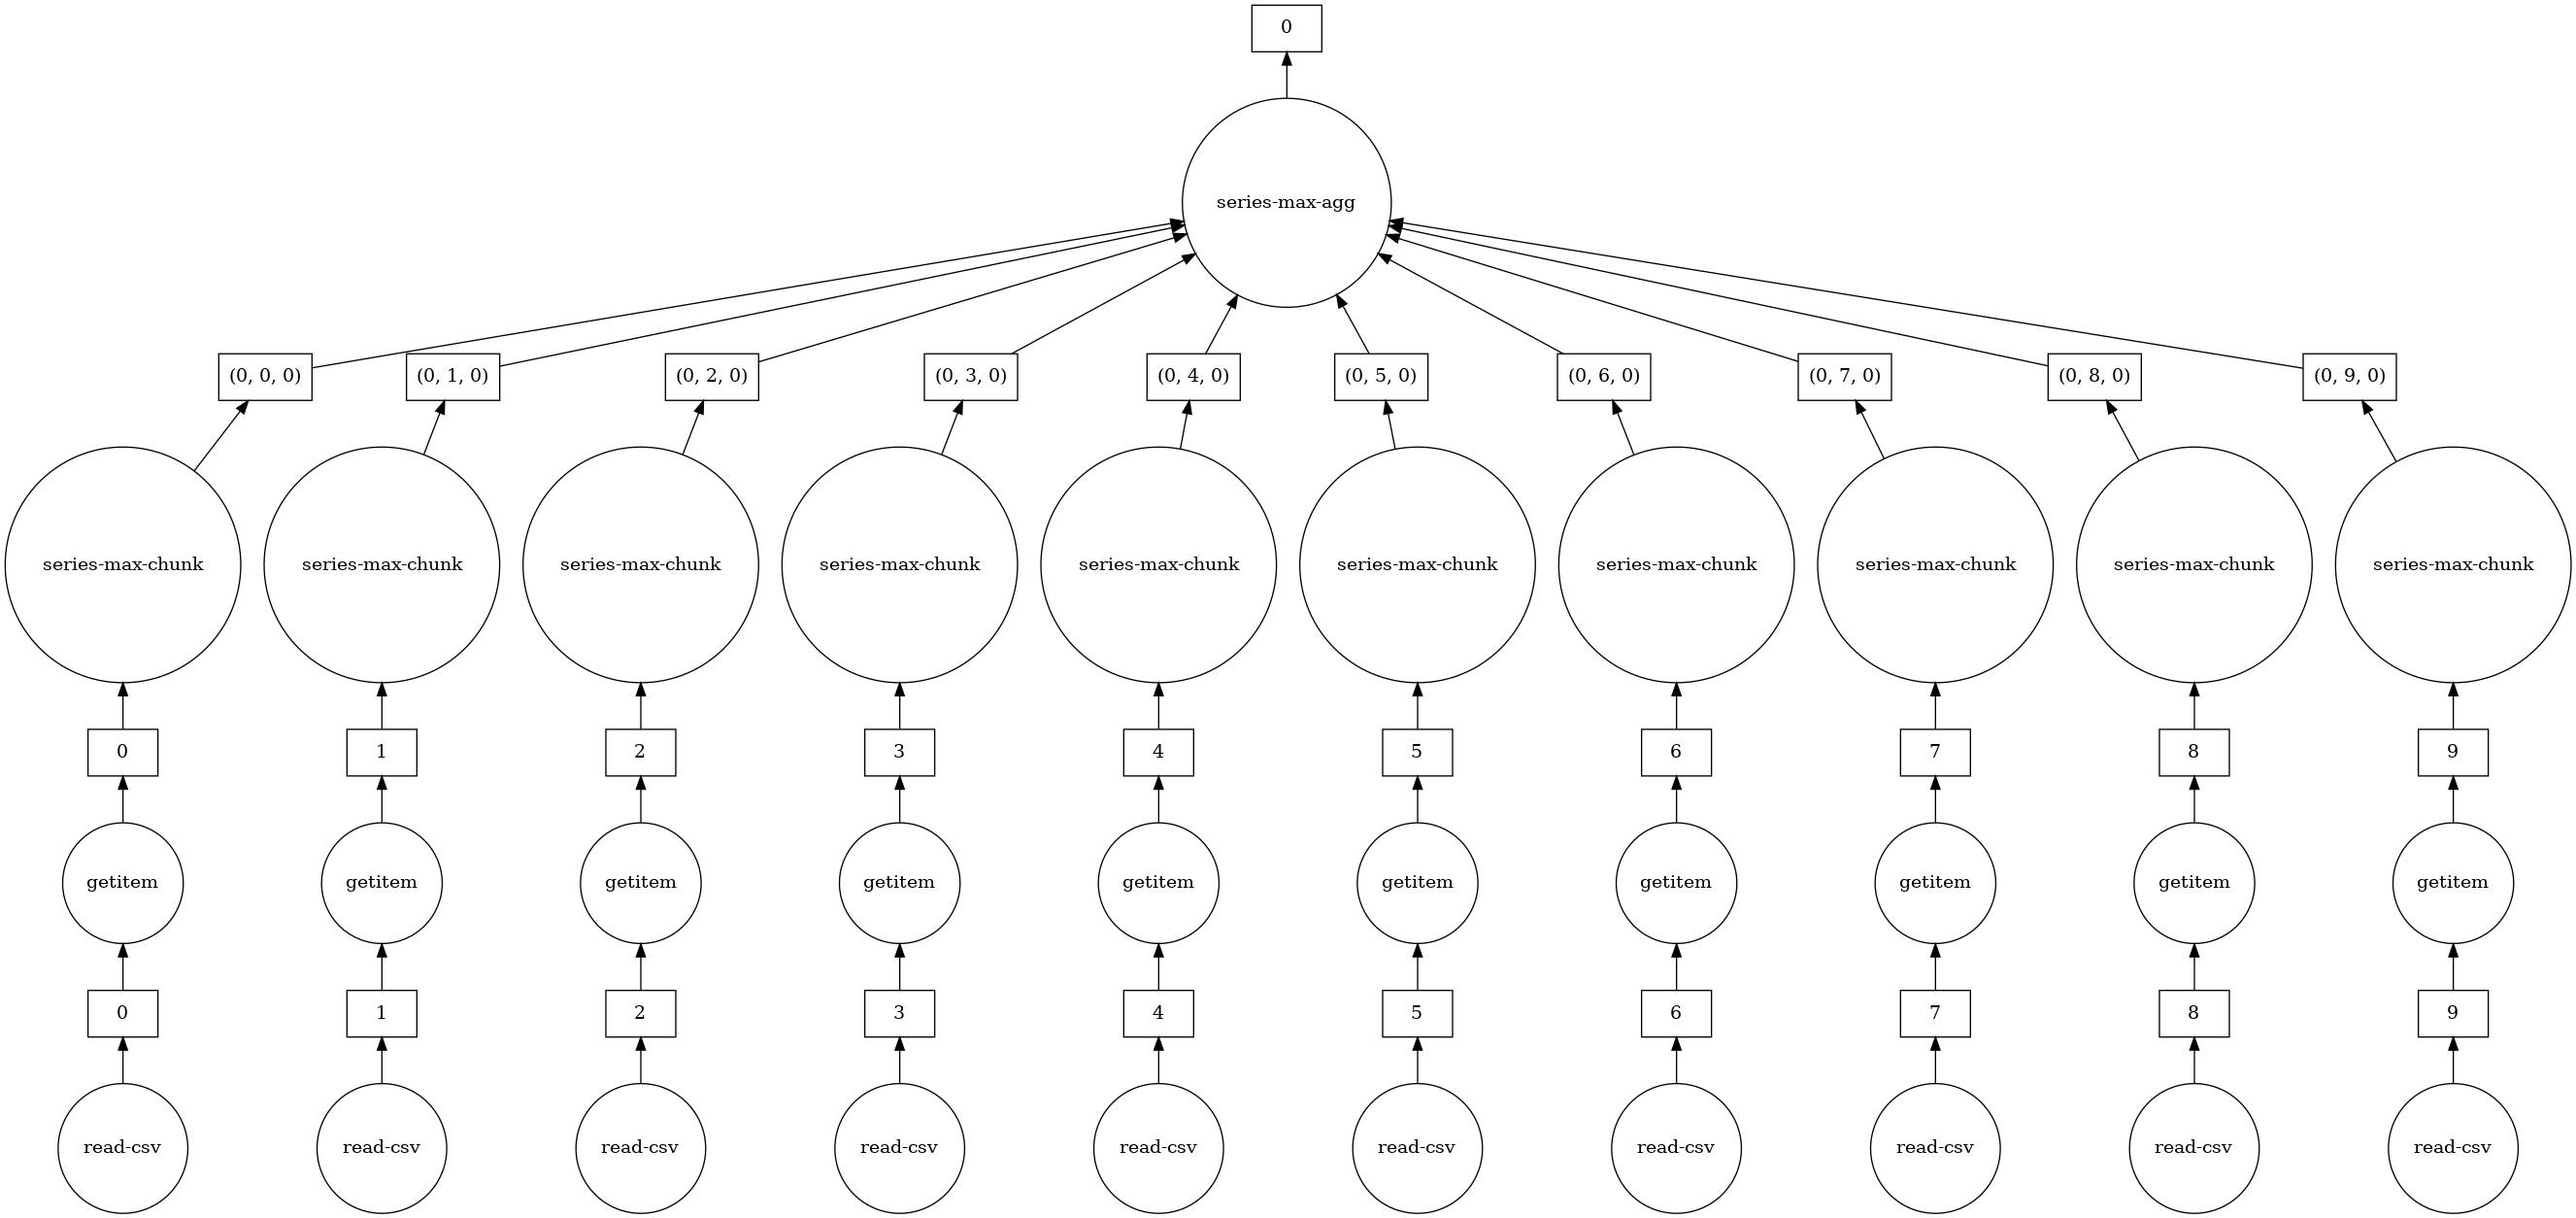

In [129]:
df.DepDelay.max().visualize()

In [130]:
df

,Date,DayOfWeek,DepTime,CRSDepTime,ArrTime,CRSArrTime,UniqueCarrier,FlightNum,TailNum,ActualElapsedTime,CRSElapsedTime,AirTime,ArrDelay,DepDelay,Origin,Dest,Distance,TaxiIn,TaxiOut,Cancelled,Diverted
npartitions=10,,,,,,,,,,,,,,,,,,,,,
,datetime64[ns],int64,float64,int64,float64,int64,object,int64,object,float64,float64,float64,float64,float64,object,object,float64,float64,float64,bool,int64
,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...


### Exercises/Questions

* How many rows are in the dataset?
* In total, how many non-canceled flights were taken?
* In total, how many non-cancelled flights were taken from each airport? 
* What was the average departure delay from each airport? 
* What day of the week has the worst average departure delay?
* Get descriptive statistics. 

In [133]:
df.head()

,Date,DayOfWeek,DepTime,CRSDepTime,ArrTime,CRSArrTime,UniqueCarrier,FlightNum,TailNum,ActualElapsedTime,...,AirTime,ArrDelay,DepDelay,Origin,Dest,Distance,TaxiIn,TaxiOut,Cancelled,Diverted
0,1990-01-01,1,1621.0,1540,1747.0,1701,US,33,NaN,86.0,...,NaN,46.0,41.0,EWR,PIT,319.0,NaN,NaN,False,0
1,1990-01-02,2,1547.0,1540,1700.0,1701,US,33,NaN,73.0,...,NaN,-1.0,7.0,EWR,PIT,319.0,NaN,NaN,False,0
2,1990-01-03,3,1546.0,1540,1710.0,1701,US,33,NaN,84.0,...,NaN,9.0,6.0,EWR,PIT,319.0,NaN,NaN,False,0
3,1990-01-04,4,1542.0,1540,1710.0,1701,US,33,NaN,88.0,...,NaN,9.0,2.0,EWR,PIT,319.0,NaN,NaN,False,0
4,1990-01-05,5,1549.0,1540,1706.0,1701,US,33,NaN,77.0,...,NaN,5.0,9.0,EWR,PIT,319.0,NaN,NaN,False,0


In [130]:
len(df)

2611892

In [131]:
len(df[~df.Cancelled])

2540961

In [132]:
df[~df.Cancelled].groupby('Origin').Origin.count().compute()

Origin
EWR    1139451
JFK     427243
LGA     974267
Name: Origin, dtype: int64

In [134]:
df.groupby("Origin").DepDelay.mean().compute()


Origin
EWR    10.295469
JFK    10.351299
LGA     7.431142
Name: DepDelay, dtype: float64

In [135]:
df.groupby("DayOfWeek").DepDelay.mean().compute()

DayOfWeek
1     8.096565
2     8.149109
3     9.141912
4    10.538275
5    11.476687
6     7.824071
7     8.994296
Name: DepDelay, dtype: float64

In [129]:
# complicated using looping over dataframes 
df.describe().compute()

,DayOfWeek,DepTime,CRSDepTime,ArrTime,CRSArrTime,FlightNum,ActualElapsedTime,CRSElapsedTime,AirTime,ArrDelay,DepDelay,Distance,TaxiIn,TaxiOut,Diverted
count,2.611892e+06,2.540961e+06,2.611892e+06,2.533682e+06,2.611892e+06,2.611892e+06,2.533682e+06,2.609927e+06,1.255069e+06,2.533682e+06,2.540961e+06,2.610397e+06,1.298886e+06,1.298886e+06,2.611892e+06
mean,3.908445e+00,1.349418e+03,1.322913e+03,1.525827e+03,1.513336e+03,7.948967e+02,1.618090e+02,1.623423e+02,1.416145e+02,8.012850e+00,9.206603e+00,9.144307e+02,6.188574e+00,2.401329e+01,2.786869e-03
std,1.983312e+00,4.614585e+02,4.731965e+02,4.875393e+02,4.950296e+02,6.328037e+02,8.517449e+01,8.388129e+01,8.479354e+01,3.458329e+01,2.897454e+01,6.527316e+02,4.636453e+00,1.664591e+01,5.271720e-02
min,1.000000e+00,1.000000e+00,0.000000e+00,1.000000e+00,0.000000e+00,1.000000e+00,-3.440000e+02,0.000000e+00,1.000000e+00,-1.437000e+03,-5.300000e+02,1.100000e+01,0.000000e+00,0.000000e+00,0.000000e+00
25%,2.000000e+00,9.260000e+02,9.200000e+02,1.134000e+03,1.135000e+03,3.440000e+02,1.180000e+02,1.180000e+02,8.300000e+01,-7.000000e+00,0.000000e+00,5.080000e+02,4.000000e+00,1.600000e+01,0.000000e+00
50%,4.000000e+00,1.430000e+03,1.430000e+03,1.547000e+03,1.546000e+03,7.230000e+02,1.610000e+02,1.610000e+02,1.280000e+02,3.000000e+00,1.000000e+00,8.720000e+02,5.000000e+00,2.300000e+01,0.000000e+00
75%,6.000000e+00,1.801000e+03,1.755000e+03,1.952000e+03,1.948000e+03,1.497000e+03,2.220000e+02,2.240000e+02,1.860000e+02,1.900000e+01,1.000000e+01,1.389000e+03,8.000000e+00,3.300000e+01,0.000000e+00
max,7.000000e+00,2.400000e+03,2.359000e+03,2.400000e+03,2.400000e+03,9.899000e+03,7.950000e+02,7.260000e+02,1.082000e+03,1.156000e+03,1.435000e+03,4.962000e+03,7.830000e+02,4.280000e+02,1.000000e+00


### Sharing intermediate results

* when computing things above, we (sometimes) did the same operation more than once 
* for most operations, `dask.dataframe` hashed the arguments, allowing duplicate computations to be shared, and only computed once
* e.g. lets compute the mean and standard deviation for departure delay of all non-canceled flights
    * if we compute them with two calls to compute, there is no sharing of intermediate computations
* using `dask.compute` merges task graphs of individual function calls

In [131]:
non_cancelled = df[~df.Cancelled]
mean_delay = non_cancelled.DepDelay.mean()
std_delay = non_cancelled.DepDelay.std()

In [132]:
%%time

mean_delay_res = mean_delay.compute()
std_delay_res = std_delay.compute()

CPU times: user 2.02 s, sys: 298 ms, total: 2.32 s
Wall time: 4.73 s


In [133]:
%time mean_delay_res, std_delay_res = dask.compute(mean_delay, std_delay)

CPU times: user 672 ms, sys: 84.1 ms, total: 756 ms
Wall time: 1.95 s


* using `dask.compute` takes roughly 1/2 the time
    * because the taskl graphts for both results are merged when calling `dask.compute` allowing shared operations to only be done once instead of twice

In [134]:
dask.visualize(mean_delay, std_delay, filename='compute_graph.pdf')

## Bag: Parallel lists for semi-structured data

* `dask.bag` is good for processing data that can be represented as a sequence of arbitrary inputs
* "messy" data, since it may contain:
    * complex nested structures
    * missing fields
    * mixtures of data types, etc.
    
* "messy" data are often encountered at the beginning of data processing pipelines when large volumes of raw data are first consumed
* the initial set of data might be JSON, CSV, XML, or any other format that does not enforce strict structure and datatypes
    * for this reason, the initial data massaging and processing is often done with Python list, dicts and sets

*  you can create a `dask.bag` from a Python sequence, from files, etc.
* use `.take(n)` to show element of the data

In [139]:
import dask.bag as db

In [140]:
data = list(range(11))
b = db.from_sequence(data, npartitions=2)

In [141]:
b.take(3)

(0, 1, 2)

### Manipulation

* `Bag` objects hold the standard functional API found in projects like the Python standard library, including `map`, `filter`, `groupby`, etc.
* operations on `Bag` objects create new bags
* call the `.compute()` method to trigger execution (as in the case for `Delayed` objects)

In [142]:
def is_even(n):
    return n % 2 == 0

In [143]:
b = db.from_sequence([1, 2, 3, 4, 5, 6, 7, 8, 9, 10])
c = b.filter(is_even).map(lambda x: x ** 2)
c

dask.bag<lambda, npartitions=10>

In [144]:
?map;

Object `map;` not found.


In [145]:
?filter;

Object `filter;` not found.


In [170]:
c.compute()

[4, 16, 36, 64, 100]

### Example: GitHub archive

* [data link](https://www.gharchive.org/)
    * downloaded zipped, and extracted in the data folder


In [204]:
import json
import os

In [183]:
bag = db.read_text('dask_data/2015-01-01-15.json').map(json.loads)

In [185]:
bag.take(2)

({'id': '2489651045',
  'type': 'CreateEvent',
  'actor': {'id': 665991,
   'login': 'petroav',
   'gravatar_id': '',
   'url': 'https://api.github.com/users/petroav',
   'avatar_url': 'https://avatars.githubusercontent.com/u/665991?'},
  'repo': {'id': 28688495,
   'name': 'petroav/6.828',
   'url': 'https://api.github.com/repos/petroav/6.828'},
  'payload': {'ref': 'master',
   'ref_type': 'branch',
   'master_branch': 'master',
   'description': "Solution to homework and assignments from MIT's 6.828 (Operating Systems Engineering). Done in my spare time.",
   'pusher_type': 'user'},
  'public': True,
  'created_at': '2015-01-01T15:00:00Z'},
 {'id': '2489651051',
  'type': 'PushEvent',
  'actor': {'id': 3854017,
   'login': 'rspt',
   'gravatar_id': '',
   'url': 'https://api.github.com/users/rspt',
   'avatar_url': 'https://avatars.githubusercontent.com/u/3854017?'},
  'repo': {'id': 28671719,
   'name': 'rspt/rspt-theme',
   'url': 'https://api.github.com/repos/rspt/rspt-theme'},
 

In [177]:
create_events = bag.filter(lambda x: x['type'] == 'CreateEvent')

In [187]:
early_events = create_events.filter(lambda x: x['created_at'] < '2015-01-01T15:00:30Z')

In [207]:
avatars_links = early_events.map(lambda x: (x['actor']['login'],x['actor']['avatar_url']))

In [208]:
av_links = avatars_links.compute()

In [209]:
av_links

[('petroav', 'https://avatars.githubusercontent.com/u/665991?'),
 ('SundeepK', 'https://avatars.githubusercontent.com/u/2339563?'),
 ('blang', 'https://avatars.githubusercontent.com/u/803897?'),
 ('PhantomWolf', 'https://avatars.githubusercontent.com/u/2059591?'),
 ('chrisduan', 'https://avatars.githubusercontent.com/u/2884455?'),
 ('maybezi', 'https://avatars.githubusercontent.com/u/3000391?'),
 ('quixing', 'https://avatars.githubusercontent.com/u/10364620?'),
 ('Abeer-y', 'https://avatars.githubusercontent.com/u/10364695?'),
 ('deeperx', 'https://avatars.githubusercontent.com/u/621232?'),
 ('blang', 'https://avatars.githubusercontent.com/u/803897?'),
 ('brunocarvalhodearaujo', 'https://avatars.githubusercontent.com/u/1646422?'),
 ('LiuSmile', 'https://avatars.githubusercontent.com/u/10350512?'),
 ('Adidaz', 'https://avatars.githubusercontent.com/u/10364741?'),
 ('yunqy', 'https://avatars.githubusercontent.com/u/10086149?')]

In [217]:
os.mkdir('github_avatars')

for author_link in av_links:
    author = author_link[0]
    link = author_link[1]
    r = requests.get(link)
    open(f'github_avatars/{author}.png','wb').write(r.content)

FileExistsError: [Errno 17] File exists: 'github_avatars'